In [115]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [116]:
data = pd.read_csv("Top_5_Leagues_23_24.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [117]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [118]:
data = add_carries(data)
data_carries = data[data['type'] == 'Carry']

In [119]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful')]

In [120]:
# Define the Zone 14 coordinates
zone14_x_min = 78
zone14_x_max = 78 + 24
zone14_y_min = 30
zone14_y_max = 30 + 20

# Add 'in_zoneF' column to data_succ_prog
data_passes['in_zoneF'] = (data_passes['x'].between(zone14_x_min, zone14_x_max) & 
                              data_passes['y'].between(zone14_y_min, zone14_y_max))

# Add 'in_zoneF' column to data_carries_succ_prog
data_carries['in_zoneF'] = (data_carries['x'].between(zone14_x_min, zone14_x_max) & 
                                      data_carries['y'].between(zone14_y_min, zone14_y_max))


# Add 'into_zoneF' column to data_succ_prog
data_passes['into_zoneF'] = (data_passes['endX'].between(zone14_x_min, zone14_x_max) & 
                              data_passes['endY'].between(zone14_y_min, zone14_y_max) & (data_passes['in_zoneF'] == False))

# Add 'into_zoneF' column to data_carries_succ_prog
data_carries['into_zoneF'] = (data_carries['endX'].between(zone14_x_min, zone14_x_max) & 
                                      data_carries['endY'].between(zone14_y_min, zone14_y_max) & (data_carries['in_zoneF'] == False))




/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_36038/1624685939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_zoneF'] = (data_passes['x'].between(zone14_x_min, zone14_x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_36038/1624685939.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_carries['in_zoneF'] = (data_carries['x'].between(zone14_x_min, zone14_x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_36038/1624685939.py:17: Settin

In [121]:
zone14_passes = data_passes[data_passes['into_zoneF']]
zone14_carries = data_carries[data_carries['into_zoneF']]

# Group and aggregate
zone14_passes_grouped = zone14_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='zone14_passes')
zone14_carries_grouped = zone14_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='zone14_carries')

result_df = pd.merge(zone14_passes_grouped, zone14_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
result_df['zone14_actions'] = result_df['zone14_passes'] + result_df['zone14_carries']

In [122]:
result_df

,playerId,player,team,zone14_passes,zone14_carries,zone14_actions
0,2987.0,Pepe Reina,Villarreal,1.0,0.0,1.0
1,4511.0,James Milner,Brighton,7.0,1.0,8.0
2,6227.0,Dani Rodríguez,Mallorca,15.0,14.0,29.0
3,6683.0,Dante,Nice,32.0,7.0,39.0
4,8166.0,Ashley Young,Everton,10.0,1.0,11.0
...,...,...,...,...,...,...
2442,505019.0,Bassirou N'diaye,Lorient,0.0,2.0,2.0
2443,515006.0,Sofiane Sidi Ali,Marseille,0.0,1.0,1.0
2444,523346.0,Ethan Wheatley,Man Utd,0.0,1.0,1.0
2445,526481.0,Mikey Moore,Tottenham,0.0,1.0,1.0


In [123]:
info = pd.read_csv("T5 Leagues Mins 23-24.csv")
info['90s'] = info['Mins'] / 90
result_df = pd.merge(result_df, info, on=['player', 'team'], how='left')

result_df['zone14_act_p90'] = result_df['zone14_actions'] / result_df['90s']
result_df = result_df[(result_df['90s'] >= 15) & (result_df['position'] != 'GK')]

top_12_players = result_df.sort_values("zone14_act_p90", ascending=False).head(12)

In [124]:
top_12_players

,playerId,player,team,zone14_passes,zone14_carries,zone14_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,zone14_act_p90
959,303139.0,Rodri,Man City,173.0,81.0,254.0,1.0,28.0,"D(C),DMC",2937.0,92.5,32.633333,7.783453
260,93894.0,Mateo Kovacic,Man City,80.0,35.0,115.0,212.0,30.0,M(CL),1549.0,94.1,17.211111,6.681730
1815,402197.0,Pedri,Barcelona,72.0,34.0,106.0,646.0,21.0,AM(CL),1476.0,87.8,16.400000,6.463415
916,299684.0,Exequiel Palacios,Leverkusen,96.0,21.0,117.0,1823.0,25.0,M(C),1841.0,92.1,20.455556,5.719718
805,279423.0,Frenkie de Jong,Barcelona,82.0,19.0,101.0,601.0,27.0,"D(C),DMC",1644.0,93.1,18.266667,5.529197
214,89401.0,Granit Xhaka,Leverkusen,99.0,58.0,157.0,1834.0,31.0,"D(L),M(C)",2828.0,92.1,31.422222,4.996464
1632,384887.0,Vitinha,PSG,76.0,39.0,115.0,2328.0,24.0,M(C),2130.0,91.3,23.666667,4.859155
1696,394786.0,Florian Wirtz,Leverkusen,91.0,36.0,127.0,1817.0,21.0,"AM(CL),FW",2384.0,84.6,26.488889,4.794463
914,299513.0,Ousmane Dembélé,PSG,62.0,18.0,80.0,2327.0,27.0,"AM(CLR),FW",1510.0,81.8,16.777778,4.768212
1588,381255.0,Billy Gilmour,Brighton,63.0,46.0,109.0,355.0,23.0,DMC,2126.0,92.2,23.622222,4.614299


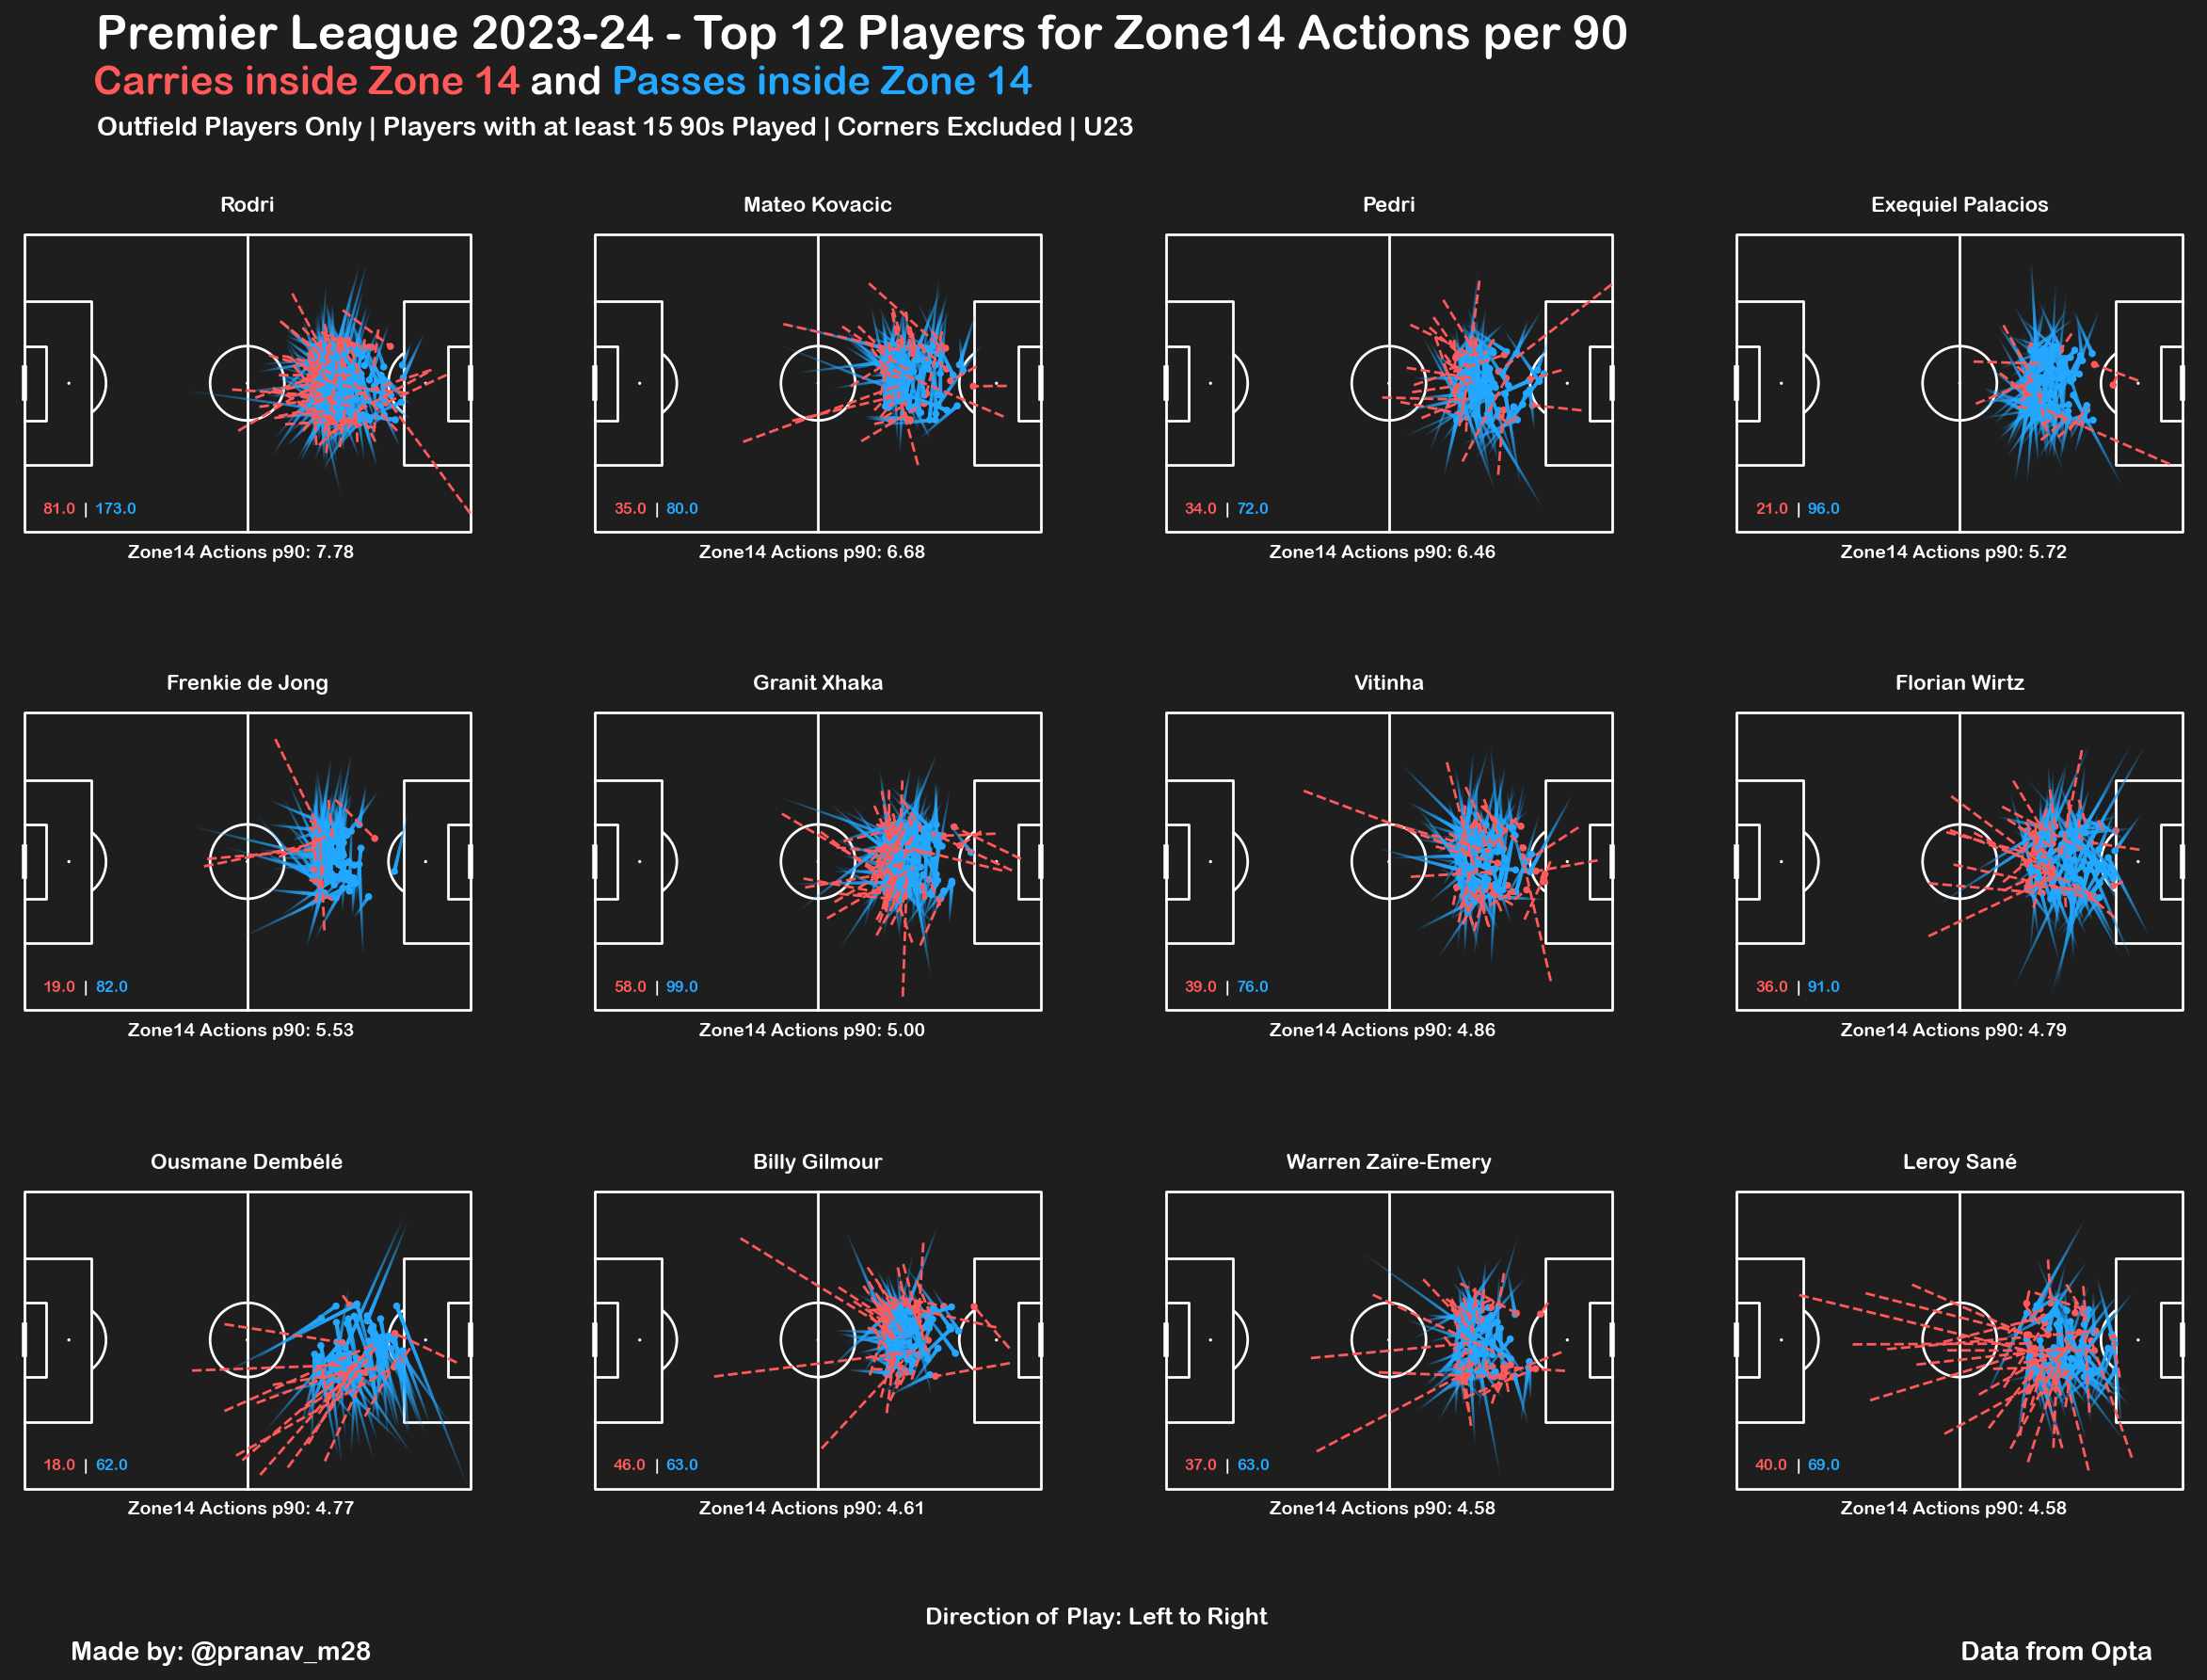

In [126]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_players.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    zone14_passes_count = player_data['zone14_passes']
    zone14_carries_count = player_data['zone14_carries']
    zone14_act_p90 = player_data['zone14_act_p90']
    
    player_passes = zone14_passes[zone14_passes['playerId'] == player_id]
    player_carries = zone14_carries[zone14_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    # Plot Zone14 Passes
    pitch.lines(player_passes.x, player_passes.y, player_passes.endX, player_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_passes.endX, player_passes.endY, s=30, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
    # Plot Zone14 Carries
    pitch.lines(player_carries.x, player_carries.y, player_carries.endX, player_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_carries.endX, player_carries.endY, s=30, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(5, 5, f'{zone14_carries_count}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(16, 5, '|', color='#FFFFFF', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(19, 5, f'{zone14_passes_count}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(28, -7, f'Zone14 Actions p90: {zone14_act_p90:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

fig_text(0.427, 1.00, "Premier League 2023-24 - Top 12 Players for Zone14 Actions per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.321, 0.97, "<Carries inside Zone 14> and <Passes inside Zone 14>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.3395, 0.94, "Outfield Players Only | Players with at least 15 90s Played | Corners Excluded | U23", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.20, 0.04, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.85, 0.04, "Data from Opta", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.510, 0.060, "Direction of Play: Left to Right", font='Arial Rounded MT Bold', size=18, ha="center", color="#FFFFFF", fontweight='bold')

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.9, bottom=0.1)
#plt.savefig('Top_12_Zone14_Actions_PL_U23.png', dpi=300, bbox_inches='tight')
plt.show()